# Regresión de datos MPG usando redes neuronales

## 1. Importando librerías y cargando datos procesados

In [38]:
import pandas as pd
import numpy as np
import warnings

from pathlib import Path
import tensorflow as tf
from tensorflow import keras
# from sklearn.model_selection import train_test_split
# script adicionales

from src.nn_desing import disenar_red_regresion
from src.load_from_zip import load_processed_data_from_zip
# sustituir si se manda a local el archivo


warnings.filterwarnings('ignore')


SEED = 7
np.random.seed(SEED)
tf.random.set_seed(SEED)

datapath = Path().resolve() / 'data'
zip_path = datapath / 'mpg_procesado.zip'




In [25]:
train_loaded, val_loaded, test_loaded, _, _, _, metadata = load_processed_data_from_zip(zip_path)

Datos extraidos correctamente


In [30]:
metadata

{'cols_num': ['displacement',
  'horsepower',
  'weight',
  'acceleration',
  'model_year',
  'cylinders'],
 'cols_cat': ['origin'],
 'cols_onehot': ['origin'],
 'cols_ordinal': [],
 'cat_out_cols': ['origin___europe', 'origin___japan', 'origin___usa'],
 'feature_names': ['displacement',
  'horsepower',
  'weight',
  'acceleration',
  'model_year',
  'cylinders',
  'origin___europe',
  'origin___japan',
  'origin___usa'],
 'target': 'mpg'}

In [32]:
X_train = train_loaded.drop(columns = ["target"])
y_train = train_loaded["target"]

X_val = val_loaded.drop(columns = ["target"])
y_val = val_loaded["target"]

X_test = test_loaded.drop(columns= ["target"])
y_test = test_loaded["target"]

print("X_train.shape = ", X_train.shape)
print("X_val.shape = ", X_val.shape)
print("X_test.shape = ", X_test.shape)

X_train.shape =  (251, 9)
X_val.shape =  (63, 9)
X_test.shape =  (79, 9)


> Los datos se han cargado correctamente

## 2. Entrenamiento

In [36]:
def build_regression_mlp(n0: int, capas: list, l2_value: float, dropouts: list) -> keras.Model:
    assert len(capas) == len(dropouts), "capas y dropouts deben tener la misma longitud"

    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(n0,)))

    for units, dr in zip(capas, dropouts):
        model.add(
            keras.layers.Dense(
                units,
                activation="relu",
                kernel_regularizer=keras.regularizers.l2(l2_value)
            )
        )
        model.add(keras.layers.Dropout(dr))

    # salida lineal
    model.add(keras.layers.Dense(1, activation="linear"))
    return model

In [33]:
d  = X_train.shape[0]   # tamaño del entrenamiento
n0 = X_train.shape[1]   # número de variables de entrada

print("d =", d)
print("n0 =", n0)


d = 251
n0 = 9


In [34]:
diseno = disenar_red_regresion(d,n0)
print(diseno)

DisenoRedRegresion(capas=[18, 9], P=361, rho=0.14382470119521912, l2=0.0003, dropouts=[0.24999999999999997, 0.21249999999999997], patience=20, min_delta=0.0001, max_epochs=400)


In [37]:
capas     = diseno.capas
l2_value  = diseno.l2
dropouts  = diseno.dropouts
patience  = diseno.patience
min_delta = diseno.min_delta
max_epochs= diseno.max_epochs


model = build_regression_mlp(n0=n0, capas=capas, l2_value=l2_value, dropouts=dropouts)

In [39]:

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse",
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.MeanSquaredError(name="mse"),
        keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 18)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │           171 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

## 3 Entrenar + validar (Early Stoping)


In [40]:
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        min_delta=min_delta,
        restore_best_weights=True,
        verbose=1
    )
]

BATCH_SIZE = 32

history = model.fit(
    X_train.astype(np.float32),
    y_train.values,
    validation_data=(X_val.astype(np.float32), y_val.values),
    epochs=max_epochs,
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 615.8658 - mae: 23.5817 - mse: 615.8583 - rmse: 24.8155 - val_loss: 627.5540 - val_mae: 23.6683 - val_mse: 627.5464 - val_rmse: 25.0509
Epoch 2/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 607.0016 - mae: 23.4032 - mse: 606.9941 - rmse: 24.6362 - val_loss: 619.7286 - val_mae: 23.5131 - val_mse: 619.7211 - val_rmse: 24.8942
Epoch 3/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 601.0121 - mae: 23.2721 - mse: 601.0046 - rmse: 24.5144 - val_loss: 612.6127 - val_mae: 23.3682 - val_mse: 612.6052 - val_rmse: 24.7509
Epoch 4/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 594.6501 - mae: 23.1542 - mse: 594.6427 - rmse: 24.3842 - val_loss: 605.7481 - val_mae: 23.2266 - val_mse: 605.7407 - val_rmse: 24.6118
Epoch 5/400
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 587.3253 - mae: 23.0116 - mse: 587.3178 - rmse: 24.2335 - val_loss: 599.0612 - val_mae: 23.0868 - val_mse: 599.0537 - val_rmse: 24.4756
Epoch 6/400
8/8 ━━━━━━━━━━━━━━

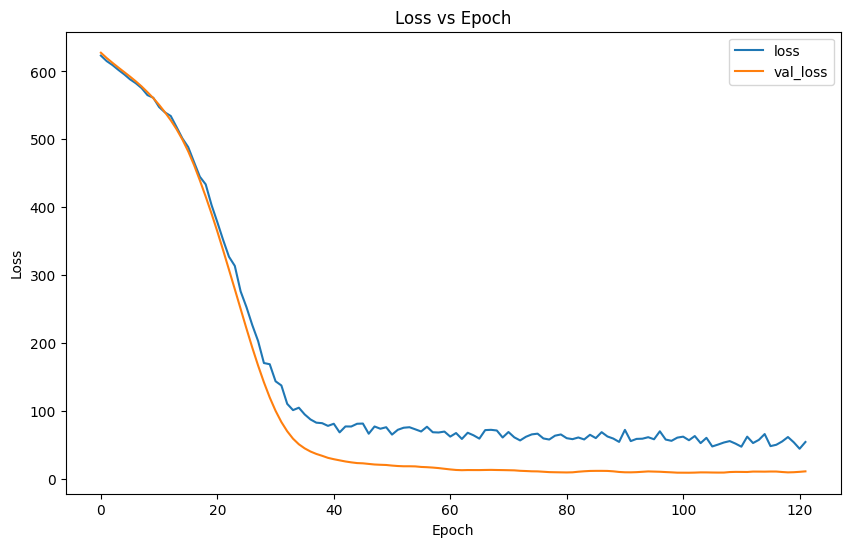

In [46]:
import matplotlib.pyplot as plt

history_df = pd.DataFrame(history.history)

figure = plt.figure(figsize=(10, 6))
ax = plt.gca()
history_df.plot(y=["loss", "val_loss"], ax=ax)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Loss vs Epoch")
plt.show()


> La mejor época es 102

## 4. Evaluando en test

In [41]:
test_metrics = model.evaluate(
    X_test.astype(np.float32),
    y_test.values,
    verbose=0,
    return_dict=True
)
print("Métricas en test:", test_metrics)

Métricas en test: {'loss': 13.309859275817871, 'mae': 2.846412181854248, 'mse': 13.297324180603027, 'rmse': 3.646549701690674}


## 5. Guardando el modelo

In [42]:
import os
import json
import zipfile
import pandas as pd

# ===========================
# 1) Rutas de salida
# ===========================
OUT_DIR = "salida_regresion"
ZIP_NAME = "resultados.zip"

os.makedirs(OUT_DIR, exist_ok=True)

# ===========================
# 2) Guardar metadatos del experimento
# ===========================
metadata = {
    "n_samples_train": int(d),
    "n_features": int(n0),
    "architecture": capas,
    "l2": float(l2_value),
    "dropouts": dropouts,
    "patience": patience,
    "min_delta": min_delta,
    "max_epochs": max_epochs,
    "metrics_test": test_metrics,
}

with open(os.path.join(OUT_DIR, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=2)

# ===========================
# 3) Guardar modelo (ya entrenado)
# ===========================
model_path = os.path.join(OUT_DIR, "modelo.keras")
model.save(model_path)

# ===========================
# 4) Guardar historial de entrenamiento
# ===========================
history_path = os.path.join(OUT_DIR, "historial_entrenamiento.csv")
pd.DataFrame(history.history).to_csv(history_path, index=False)

# ===========================
# 5) Empaquetar todo en ZIP
# ===========================
with zipfile.ZipFile(ZIP_NAME, "w", zipfile.ZIP_DEFLATED) as zipf:
    for file in [model_path, history_path, os.path.join(OUT_DIR, "metadata.json")]:
        zipf.write(file, arcname=os.path.basename(file))

print(f"ZIP generado correctamente: {ZIP_NAME}")


ZIP generado correctamente: resultados.zip
